# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Download Input data set and Apply summary statistics

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       ])

In [3]:
train = datasets.MNIST('./data', train=True, download=True,  transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True,  transform=test_transforms)

In [4]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())
train_data_mean = torch.mean(train_data)
train_data_std = torch.std(train_data)
print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', train_data_mean)
print(' - std:', train_data_std)
print(' - var:', torch.var(train_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


/Users/vehere/anaconda3/envs/torch-nightly/lib/python3.8/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


# Data Transformation
performed 2 basic transformations
1. ToTensor
2. Normalize

In [5]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(train_data_std, train_data_std ), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(train_data_std, train_data_std ), #(0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [6]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders

In [7]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


# Display a single Digit from MNIST dataset

torch.Size([64, 1, 28, 28])
torch.Size([64])


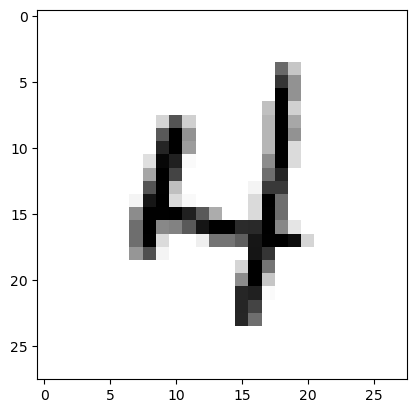

In [8]:

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

# Display an array of random images from dataset


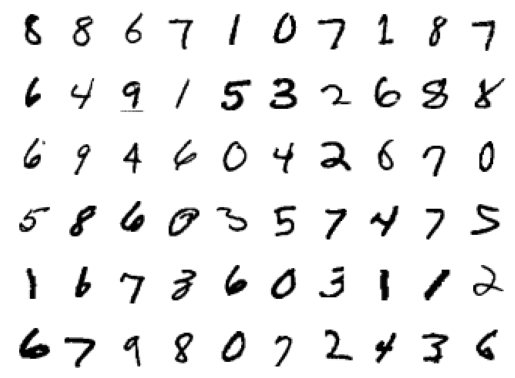

In [9]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Model Params

Can't emphasize on how important viewing Model Summary is. Unfortunately, there is no in-built model visualizer, so we have to take external help

In [10]:
!pip install torchsummary
from torchsummary import summary
from model import Net4
use_cuda = torch.cuda.is_available()
device = torch.device(use_cuda if use_cuda else "cpu")
print(device)
model = Net4().to(device)
summary(model, input_size=(1, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
            Conv2d-3           [-1, 16, 28, 28]           1,168
       BatchNorm2d-4           [-1, 16, 28, 28]              32
         MaxPool2d-5           [-1, 16, 14, 14]               0
           Dropout-6           [-1, 16, 14, 14]               0
            Conv2d-7           [-1, 20, 14, 14]           2,900
       BatchNorm2d-8           [-1, 20, 14, 14]              40
            Conv2d-9           [-1, 16, 14, 14]           2,896
      BatchNorm2d-10           [-1, 16, 14, 14]              32
        MaxPool2d-11             [-1, 16, 7, 7]               0
          Dropout-12             [-1, 16, 7, 7]               0
           Conv2d-13             [-1, 20, 5, 5]           2,900
      BatchNorm2d-14             [-

/Users/vehere/ERA_V2/ERA_v2.0/s7/model.py:121: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments.

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [11]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Train and test Net4 model

In [12]:
device = torch.device("mps")
model =  Net4().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.04928279668092728 Batch_id=937 Accuracy=91.97: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:17<00:00, 54.61it/s]



Test set: Average loss: 0.0438, Accuracy: 9857/10000 (98.57%)

EPOCH: 1


Loss=0.007272606249898672 Batch_id=937 Accuracy=97.45: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 68.78it/s]



Test set: Average loss: 0.0343, Accuracy: 9879/10000 (98.79%)

EPOCH: 2


Loss=0.04705318063497543 Batch_id=937 Accuracy=97.96: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:14<00:00, 64.89it/s]



Test set: Average loss: 0.0309, Accuracy: 9889/10000 (98.89%)

EPOCH: 3


Loss=0.0055764042772352695 Batch_id=937 Accuracy=98.18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:14<00:00, 66.85it/s]



Test set: Average loss: 0.0262, Accuracy: 9902/10000 (99.02%)

EPOCH: 4


Loss=0.07112979888916016 Batch_id=937 Accuracy=98.46: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 68.62it/s]



Test set: Average loss: 0.0251, Accuracy: 9917/10000 (99.17%)

EPOCH: 5


Loss=0.015005550347268581 Batch_id=937 Accuracy=98.61: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:14<00:00, 66.89it/s]



Test set: Average loss: 0.0228, Accuracy: 9927/10000 (99.27%)

EPOCH: 6


Loss=0.03876574710011482 Batch_id=937 Accuracy=98.66: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:14<00:00, 66.52it/s]



Test set: Average loss: 0.0205, Accuracy: 9931/10000 (99.31%)

EPOCH: 7


Loss=0.014771349728107452 Batch_id=937 Accuracy=98.75: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 68.43it/s]



Test set: Average loss: 0.0194, Accuracy: 9936/10000 (99.36%)

EPOCH: 8


Loss=0.03460056707262993 Batch_id=937 Accuracy=98.82: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 70.86it/s]



Test set: Average loss: 0.0208, Accuracy: 9926/10000 (99.26%)

EPOCH: 9


Loss=0.04063122346997261 Batch_id=937 Accuracy=98.86: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 71.21it/s]



Test set: Average loss: 0.0356, Accuracy: 9876/10000 (98.76%)

EPOCH: 10


Loss=0.11966638267040253 Batch_id=937 Accuracy=98.89: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 69.38it/s]



Test set: Average loss: 0.0179, Accuracy: 9943/10000 (99.43%)

EPOCH: 11


Loss=0.0076130349189043045 Batch_id=937 Accuracy=98.99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 70.66it/s]



Test set: Average loss: 0.0193, Accuracy: 9937/10000 (99.37%)

EPOCH: 12


Loss=0.0026153114158660173 Batch_id=937 Accuracy=99.01: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:14<00:00, 66.83it/s]



Test set: Average loss: 0.0195, Accuracy: 9934/10000 (99.34%)

EPOCH: 13


Loss=0.0010670680785551667 Batch_id=937 Accuracy=99.04: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 70.37it/s]



Test set: Average loss: 0.0189, Accuracy: 9935/10000 (99.35%)

EPOCH: 14


Loss=0.08602111041545868 Batch_id=937 Accuracy=99.00: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 68.12it/s]



Test set: Average loss: 0.0180, Accuracy: 9940/10000 (99.40%)

EPOCH: 15


Loss=0.05708444118499756 Batch_id=937 Accuracy=98.99: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 70.75it/s]



Test set: Average loss: 0.0218, Accuracy: 9923/10000 (99.23%)

EPOCH: 16


Loss=0.00030551516101695597 Batch_id=937 Accuracy=99.12: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:12<00:00, 76.32it/s]



Test set: Average loss: 0.0172, Accuracy: 9942/10000 (99.42%)

EPOCH: 17


Loss=0.007814413867890835 Batch_id=937 Accuracy=99.08: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:12<00:00, 78.02it/s]



Test set: Average loss: 0.0187, Accuracy: 9940/10000 (99.40%)

EPOCH: 18


Loss=0.053807493299245834 Batch_id=937 Accuracy=99.12: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:12<00:00, 76.01it/s]



Test set: Average loss: 0.0173, Accuracy: 9937/10000 (99.37%)

EPOCH: 19


Loss=0.056754231452941895 Batch_id=937 Accuracy=99.17: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:12<00:00, 73.75it/s]



Test set: Average loss: 0.0173, Accuracy: 9942/10000 (99.42%)



# Train Vs Test Loss Plot

In [13]:
t = [t_items.item() for t_items in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

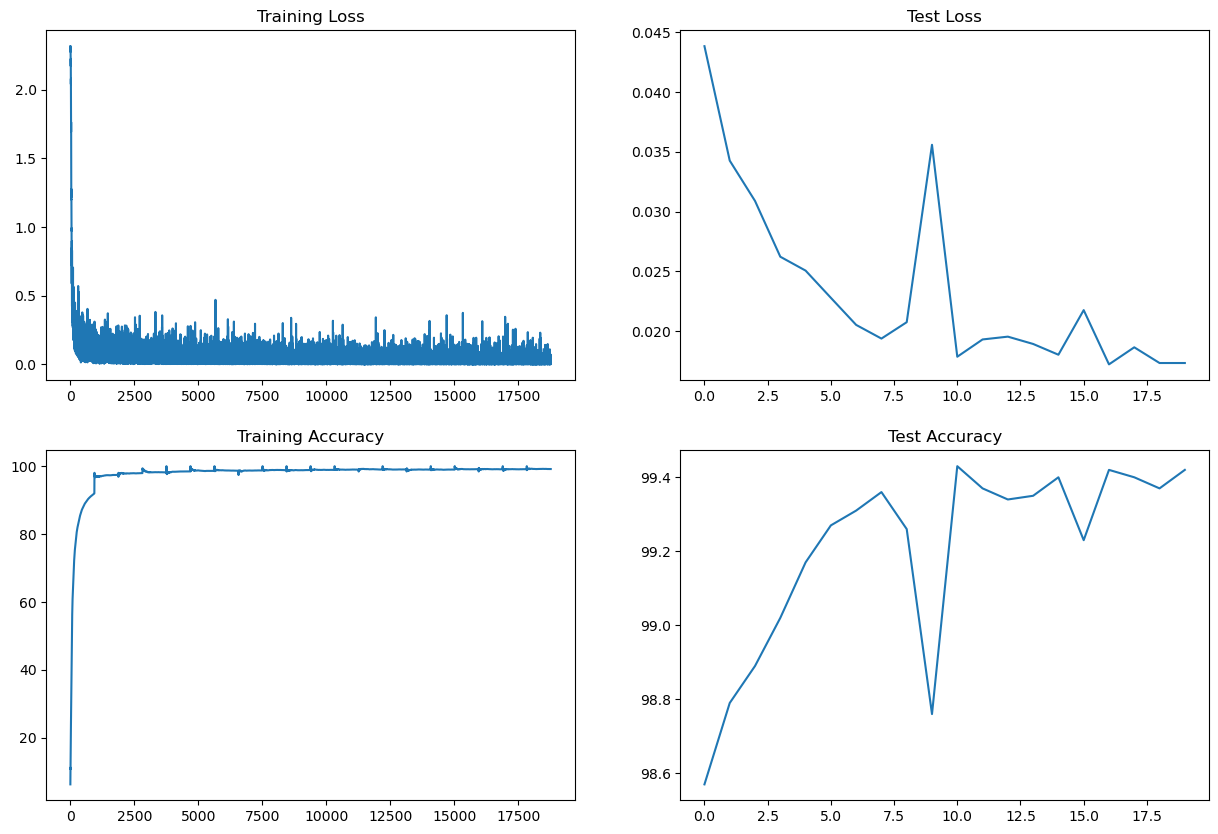

In [14]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Target:
* Create light weight model (Net4) with lesser paramerter(14.5k) than basic Model(Net3 with 17,354 parameters). <br>
* Introduce Drop out of 0.3 after every convolution transition block. <br>
* Reduce the max kernel parameter 20 against 24 in the previous model(Net3), this reduces the overall trainable parameters. <br>
## Results:
* Parameters: 14.5k (14,450) <br>
* Best Training Accuracy: 99.19 <br>
* Best Test Accuracy: 99.42 <br>
## Analysis:
* Net4 is much roubust light weight model with 14.5k parameters and consistently produced test accuracy of ~ 99.35 to 99.43% in multiple epochs.<br>
* After added dropout, the overfitting problem was resolved, the max training accuracy is 99.19% and there is scope for additional improvement in training and to increase test accuracy further.<br>